In [123]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from apyori import apriori

labels = {
    0: 'Nucleoplasm', 
    1: 'Nuclear membrane', 
    2: 'Nucleoli', 
    3: 'Nucleoli fibrillar center',
    4: 'Nuclear speckles', 
    5: 'Nuclear bodies', 
    6: 'Endoplasmic reticulum', 
    7: 'Golgi apparatus', 
    8: 'Intermediate filaments', 
    9: 'Actin filaments', 
    10: 'Microtubules', 
    11: 'Mitotic spindle', 
    12: 'Centrosome', 
    13: 'Plasma membrane', 
    14: 'Mitochondria', 
    15: 'Aggresome', 
    16: 'Cytosol', 
    17: 'Vesicles and punctate cytosolic patterns', 
    18: 'Negative',
    19: 'None'}

my_cols = ['Label-%s'%i for i in range(1, 7)]
df_train_labels = pd.read_csv('train-3.csv', sep='\||,', names=my_cols, 
                              engine='python')
# Rename the first-col
df_train_labels = df_train_labels.rename(columns={'Label-1': 'ID', 'Label-2':'Label-1',
                                                  'Label-3':'Label-2', 'Label-4':'Label-3',
                                                  'Label-5':'Label-4', 'Label-6':'Label-5'})

# Drop the first row since the default labels remain
df_train_labels = df_train_labels.drop(df_train_labels.index[0])
df_train_labels.head()

,ID,Label-1,Label-2,Label-3,Label-4,Label-5
1,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8,5.0,0.0,NaN,NaN
2,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14,0.0,NaN,NaN,NaN
3,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6,1.0,NaN,NaN,NaN
4,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16,10.0,NaN,NaN,NaN
5,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14,0.0,NaN,NaN,NaN


In [95]:
# Replace all Nan with zero and change astype to int
df_mod = df_train_labels.fillna(19)

# Change all Label cols to type(int)
df_mod['Label-1'] = df_mod['Label-1'].astype(int)
df_mod['Label-2'] = df_mod['Label-2'].astype(int)
df_mod['Label-3'] = df_mod['Label-3'].astype(int)
df_mod['Label-4'] = df_mod['Label-4'].astype(int)
df_mod['Label-5'] = df_mod['Label-5'].astype(int)

# See modified dataframe
df_mod.head()

,ID,Label-1,Label-2,Label-3,Label-4,Label-5
1,5c27f04c-bb99-11e8-b2b9-ac1f6b6435d0,8,5,0,19,19
2,5fb643ee-bb99-11e8-b2b9-ac1f6b6435d0,14,0,19,19,19
3,60b57878-bb99-11e8-b2b9-ac1f6b6435d0,6,1,19,19,19
4,5c1a898e-bb99-11e8-b2b9-ac1f6b6435d0,16,10,19,19,19
5,5b931256-bb99-11e8-b2b9-ac1f6b6435d0,14,0,19,19,19


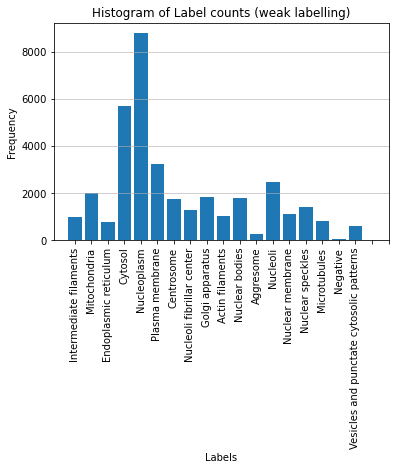

In [52]:
# Plot histograms/bar-plots for each label


# Count occurences
label_cols = ['Label-1', 'Label-2', 'Label-3', 'Label-4', 'Label-5']
label_count = {}
for col in label_cols:
    for val in df_mod[col]:
        if labels[val] in label_count.keys():
            label_count[labels[val]] += 1
        else:
            label_count[labels[val]] = 1

# Sort the dict
sorted_label_count = {k:v for k, v in sorted(label_count.items(), key=lambda item: item[0])}

# Plot a bar-chart
plt.bar(list(label_count.keys())[0:-2], list(label_count.values())[0:-2])

plt.title('Histogram of Label counts (weak labelling)')
plt.xlabel('Labels')
plt.ylabel('Frequency')

# Adjust the xticks on the histogram
plt.xticks(rotation=90)
plt.xticks(np.arange(0, 20, 1))
plt.grid(axis='y', alpha=0.75)

# Results - Bar plot:
#  - nucleoplasm appears in most images, in ~9k images
#. - cytosol next, in ~5.8k images
#. - plasma membrane in ~3k images .. Aggresome and Negative appear the least. 

In [76]:
# Based on weak labels (from csv), it would be interesting to study
# any association. This specially helps us since we don't hold 
# life-science/biology degrees.

# Apriori/Association rule mining techniques
records = []

# Get the row, col from shape and form list of lists essentially,
# each inner list representing a row of Label-1, .. Label-5
shape = df_mod.shape
rows = shape[0]
cols = shape[1]

for row in range(0, rows):
    records.append([str(df_mod.values[row, col]) for col in range(1, cols)])

[['14', '0', '19', '19', '19'], ['6', '1', '19', '19', '19'], ['16', '10', '19', '19', '19'], ['14', '0', '19', '19', '19'], ['0', '19', '19', '19', '19'], ['14', '19', '19', '19', '19'], ['13', '0', '19', '19', '19'], ['12', '0', '19', '19', '19'], ['14', '19', '19', '19', '19']]


In [89]:
# Choosing support, confidence and lift parameters
#  - Support: Popularity index
#    Support(A) = Transactions with (A) / Total transactions 
#. - Min-confidence: Likelihood that B also occurs when A occurs
#.   Confidence(A->B) = Transactions with (A+B) / Total transactions with A
#  - Min-lift: Increase in occurence B when A occurs
#    Lift(A->B) = Confidence(A->B) / Support(A)   
association_rules = apriori(records, min_support=0.00045, min_confidence=0.2, min_lift=2, min_length=2)
association_results = list(association_rules)

In [153]:
# Print out all the associations
df_arm = pd.DataFrame(columns = ['Association', 'Support', 'Confidence', 'Lift'])

o_index = 0
for res in association_results:
    items = list(res[0])
    items_link = ''
    for i_index in range(len(items)):
        if i_index == len(items) - 1:
            items_link += labels[int(items[i_index])]
        else:
            items_link += labels[int(items[i_index])] + ' -> '      
    support = res[1]
    confidence = res[2][0][2]
    lift = res[2][0][3]
    df_arm.loc[o_index] = [items_link, support, confidence, lift]
    o_index += 1

# Display the result df comprising the ARM results
df_arm

# Results:
# --------
# Nucleoplasm, Mitochondria and Vesicles appear together 87% of time
# Nuclear bodies, Nucleoplasm and Vesicles appear together 83% of time
# Nucleoplasm, Cytosol and Mitotic spindle appear together 57% of time
# Microtubules and Mitotic spindle appear together 28% of time
# All remaining combinations appear 25-26% time:
#.  - Nucleoli -> Mitochondria -> Plasma membrane
#   - Nucleoli -> Cytosol -> Endoplasmic reticulum
#   - Nucleoli -> Nucleoplasm -> Cytosol -> Intermediate filaments

,Association,Support,Confidence,Lift
0,Microtubules -> Mitotic spindle,0.001009,0.282051,7.518839
1,Nucleoplasm -> Cytosol -> Mitotic spindle,0.000780,0.566667,2.173568
2,Nucleoplasm -> Mitochondria -> Vesicles and pu...,0.000642,0.875000,2.168950
3,Nuclear bodies -> Nucleoplasm -> Vesicles and ...,0.000459,0.833333,2.065666
4,Microtubules -> Mitotic spindle -> None,0.001009,0.282051,7.518839
5,Nucleoli -> Mitochondria -> Plasma membrane,0.000917,0.259740,2.310851
6,Nucleoli -> Cytosol -> Endoplasmic reticulum,0.001513,0.268293,2.386940
7,Nucleoplasm -> Cytosol -> Mitotic spindle -> None,0.000780,0.566667,2.174715
8,Nucleoplasm -> Mitochondria -> None -> Vesicle...,0.000642,0.875000,2.169443
9,Nucleoli -> Nucleoplasm -> Cytosol -> Intermed...,0.000780,0.265625,2.403410
